In [1]:
import sys

!{sys.executable} -m pip install torch
!{sys.executable} -m pip install qiskit
!{sys.executable} -m pip install pylatexenc
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install itertools

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
You should consider upgrading via the '/usr

In [2]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

In [3]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np

In [4]:
from tqdm import tqdm

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
np.random.seed(123)

torch.manual_seed(123)

import random
random.seed(123)

NUM_QUBITS = 4
NUM_SHOTS = 5000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [7]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools

def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


# Construct QuantumCircuit QFT Class

In [8]:
class QuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.thetas = { k: Parameter('Theta'+str(k)) for k in range(self.n_qubits) }
        
        all_qubits = [i for i in range(n_qubits)]
        
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
            
        self.circuit.measure_all()
        
        self.backend = backend
        self.shots = shots
        
    def N_qubits_expectation_Z(self, counts, shots, n_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) / shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        
        job_sim = execute(self.circuit, 
                          self.backend, 
                          shots = self.shots, 
                          parameter_binds = [{ self.thetas[k]: params[k].item() for k in range(self.n_qubits) }])
        
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        
        return self.N_qubits_expectation_Z(counts, self.shots, self.n_qubits)

Expected value for rotation [pi/4]: [0.0006 0.0026 0.0028 0.0178 0.0022 0.0158 0.0168 0.0896 0.0028 0.0158
 0.015  0.0904 0.014  0.0872 0.093  0.5336]


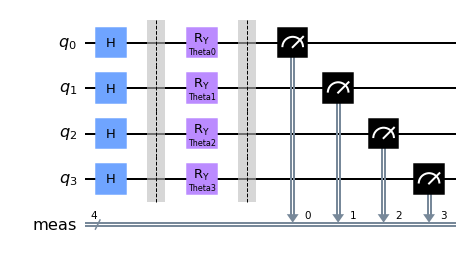

In [9]:
circuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print(f'Expected value for rotation [pi/4]: {circuit.run(torch.Tensor([np.pi/4] * len(QC_OUTPUTS)))}')
circuit.circuit.draw(output='mpl')

In [10]:
class TorchCircuit(Function):
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QuantumCircuit'):
            ctx.QuantumCircuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
        
        exp_value = ctx.QuantumCircuit.run(i)
        
        result = torch.Tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor,i = ctx.saved_tensors
        
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
            expectation_right = ctx.QuantumCircuit.run(shift_right)
            expectation_left = ctx.QuantumCircuit.run(shift_left)
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradient = gradient / torch.norm(gradient)
            
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
        
        return (result.float() * grad_output.float()).T

In [11]:
x = torch.tensor([np.pi/4] * NUM_QUBITS, requires_grad=True)
qc = TorchCircuit.apply

y1 = qc(x)
print(f'y1 after quantum layer: {y1}')
y1 = nn.Linear(2**NUM_QUBITS, 1)(y1.float())

y1.backward()
print(f'x.grad = {x.grad}')

y1 after quantum layer: tensor([[0.0010, 0.0028, 0.0028, 0.0148, 0.0036, 0.0158, 0.0154, 0.0874, 0.0034,
         0.0144, 0.0158, 0.0890, 0.0176, 0.0980, 0.0900, 0.5282]],
       grad_fn=<TorchCircuitBackward>)
x.grad = tensor([ 0.0725,  0.0334, -0.1611,  0.0716])


100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


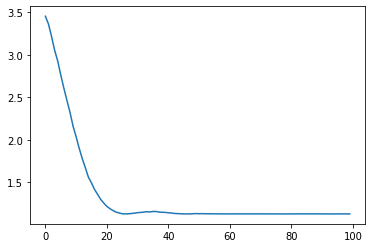

In [12]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    
    val = sum([(i + 1) * expval[i] for i in range(2**NUM_QUBITS)]) / 2**NUM_QUBITS
    
    return torch.abs(target - val) ** 2, expval


x = torch.tensor([np.pi/4] * NUM_QUBITS, requires_grad=True)
opt = optim.Adam([x], lr = 0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)
    
plt.plot(loss_list)

In [13]:
from torch.functional import F

In [14]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

n_samples = 100

X_train = datasets.FashionMNIST(root='./data', 
                                train=True,
                                download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 6)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 7)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 8)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 9)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

In [15]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

In [16]:
n_samples = 50

X_test = datasets.FashionMNIST(root='./data', 
                               train=False,
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 6)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 7)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 8)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 9)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

In [17]:
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

# Building network

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS)
        self.qc = TorchCircuit.apply
        self.qcsim = nn.Linear(NUM_QUBITS, 2**NUM_QUBITS)
        self.fc3 = nn.Linear(1, 3) # todo: is it correct???
        
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = np.pi*torch.tanh(x)
        
        MODE = 'QC'
        
        if MODE == 'QC':
            x = self.qc(x[0])
        else:
            x = self.qcsim(x)
            
        x = torch.sigmoid(x)
        x = torch.cat((x, 1-x), -1)
        
        return x
    
    
    def predict(self, x):
        
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        
        return torch.tensor(ans)
    
network = Net()
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [19]:
def train_network(network, optimizer, train_loader, val_loader):
    epochs = 25
    loss_func = nn.CrossEntropyLoss()

    loaders = {
        'train': train_loader,
        'val': val_loader
    }
    
    loss_results = {
        'train': [],
        'val': []
    }

    acc_results = {
        'train': [],
        'val': []
    }

    loaders = {
        'train': train_loader,
        'val': test_loader
    }

    for epoch in range(epochs):
        total_loss = {
            'train': [],
            'val': []
        }

        total_acc = {
            'train': [],
            'val': []
        }


        for phase in ['train', 'val']:
            if phase == 'train':
                network.train(True)
            else:
                network.train(False)

            correct = 0
            number = 0

            for batch_idx, (data, target) in enumerate(loaders[phase]):
                optimizer.zero_grad()
                output = network(data)

                loss = loss_func(output, target)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                total_loss[phase].append(loss.item())

                _, predicted = torch.max(output.data, 1)
                number += target.size(0)
                correct += (predicted == target).sum().item()

            loss_results[phase].append(sum(total_loss[phase]) / len(total_loss[phase]))
            acc_results[phase].append(100 * correct / number)

        progress = 100.0 * (epoch + 1) / epochs

        print(f'Training [{int(progress)}%]\tTraining loss {loss_results["train"][-1]}\tValidation loss {loss_results["val"][-1]}\tTraining acc {acc_results["train"][-1]}\tValidation acc {acc_results["val"][-1]}')
        
    return {
        'train_loss': loss_results["train"][-1],
        'val_loss': loss_results["val"][-1],
        'train_acc': acc_results["train"][-1],
        'val_acc': acc_results["val"][-1]
    }


In [20]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, ConcatDataset

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

dataset = ConcatDataset([X_train, X_test])

k_folds = 5

kfold = KFold(n_splits=k_folds, shuffle=True)

results = {}

print('--------------------------------')

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
  
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=1, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=1, sampler=test_subsampler)

    network = Net()
    network.apply(reset_weights)
    
    optimizer = optim.Adam(network.parameters(), lr=0.001)
    
    result = train_network(network, optimizer, trainloader, testloader)
    
    results[fold] = result
    
    print(result)
    print('--------------------------------')

print('--------------------------------')
print('FINAL RESULTS')
print('--------------------------------')
print(results)

--------------------------------
FOLD 0
--------------------------------
Training [4%]	Training loss 3.412743222117424	Validation loss 3.3863845114707947	Training acc 29.25	Validation acc 39.0
Training [8%]	Training loss 3.392769466638565	Validation loss 3.3606454162597656	Training acc 39.666666666666664	Validation acc 51.8
Training [12%]	Training loss 3.382448619604111	Validation loss 3.354535479068756	Training acc 45.416666666666664	Validation acc 54.0
Training [16%]	Training loss 3.3747333246469498	Validation loss 3.3484267201423643	Training acc 48.916666666666664	Validation acc 57.6
Training [20%]	Training loss 3.372715678612391	Validation loss 3.34963121509552	Training acc 50.0	Validation acc 58.2
Training [24%]	Training loss 3.367258517940839	Validation loss 3.346794698238373	Training acc 52.75	Validation acc 59.2
Training [28%]	Training loss 3.365812877813975	Validation loss 3.345061312675476	Training acc 54.0	Validation acc 57.0
Training [32%]	Training loss 3.3638612218697865	V

Training [44%]	Training loss 3.3650719207525253	Validation loss 3.3348213572502137	Training acc 50.833333333333336	Validation acc 60.8
Training [48%]	Training loss 3.3615991099675497	Validation loss 3.3347389669418335	Training acc 52.75	Validation acc 61.0
Training [52%]	Training loss 3.361824887394905	Validation loss 3.3308657784461975	Training acc 52.833333333333336	Validation acc 63.2
Training [56%]	Training loss 3.355186068813006	Validation loss 3.327462507724762	Training acc 56.666666666666664	Validation acc 64.0
Training [60%]	Training loss 3.3558429485559462	Validation loss 3.331988875389099	Training acc 54.833333333333336	Validation acc 66.0
Training [64%]	Training loss 3.357035224835078	Validation loss 3.334394080162048	Training acc 54.166666666666664	Validation acc 63.0
Training [68%]	Training loss 3.355073445836703	Validation loss 3.3241501603126524	Training acc 54.75	Validation acc 66.4
Training [72%]	Training loss 3.3542791761954627	Validation loss 3.3277336592674254	Train

Training [88%]	Training loss 3.35987105846405	Validation loss 3.337588036060333	Training acc 53.75	Validation acc 58.0
Training [92%]	Training loss 3.3574835431575774	Validation loss 3.3374877672195433	Training acc 54.0	Validation acc 59.2
Training [96%]	Training loss 3.3582274864117303	Validation loss 3.334735475063324	Training acc 53.75	Validation acc 60.6
Training [100%]	Training loss 3.3576353722810746	Validation loss 3.341916234493256	Training acc 53.75	Validation acc 58.6
{'train_loss': 3.3576353722810746, 'val_loss': 3.341916234493256, 'train_acc': 53.75, 'val_acc': 58.6}
--------------------------------
--------------------------------
FINAL RESULTS
--------------------------------
{0: {'train_loss': 3.355568449497223, 'val_loss': 3.330477029800415, 'train_acc': 55.833333333333336, 'val_acc': 64.2}, 1: {'train_loss': 3.3558279138803484, 'val_loss': 3.332840115070343, 'train_acc': 56.083333333333336, 'val_acc': 60.8}, 2: {'train_loss': 3.348200871149699, 'val_loss': 3.3224697132

In [21]:
# epochs = 25
# loss_func = nn.CrossEntropyLoss()

# loss_results = {
#     'train': [],
#     'val': []
# }

# loaders = {
#     'train': train_loader,
#     'val': test_loader
# }

# for epoch in range(epochs):
#     total_loss = {
#         'train': [],
#         'val': []
#     }
    
#     for phase in ['train', 'val']:
#         if phase == 'train':
#             network.train(True)
#         else:
#             network.train(False)
        
#         for batch_idx, (data, target) in enumerate(loaders[phase]):
#             optimizer.zero_grad()
#             output = network(data)
#             loss = loss_func(output, target)
            
#             if phase == 'train':
#                 loss.backward()
#                 optimizer.step()

#             total_loss[phase].append(loss.item())

# #             total_train_loss.append(loss.item())

#         loss_results[phase].append(sum(total_loss[phase]) / len(total_loss[phase]))

# #         loss_train_list.append(sum(total_train_loss) / len(total_train_loss))
#     progress = 100.0 * (epoch + 1) / epochs
    
#     print(f'Training [{int(progress)}%]')
#     print(f'Training loss {loss_results}')
# #     print(f'Training loss {loss_results['train'][-1]}')
# #     print(f'Validation loss {loss_results['val'][-1]}')
# #     print(f'Training [{int(progress)}%]\tTraining loss {loss_results['train'][-1]}\tValidation loss {loss_results['val'][-1]}')
    

In [22]:
# plt.plot(loss_results['val'])
# plt.title(f'Hybrid NN training convergence for {NUM_QUBITS}-qubits')
# plt.xlabel('epoch')
# plt.ylabel('loss')

# Test accuracy

In [23]:
# accuracy = 0
# number = 0
# for batch_idx, (data, target) in enumerate(test_loader):
#     number += 1
#     output = network.predict(data).item()
#     accuracy += (output == target[0].item())*1

In [24]:
# print(f'Performance on test data: {accuracy}/{number} = {accuracy/number*100}%')

In [25]:
# n_sample_shape = (8, 6)
# count = 0
# fig, axes = plt.subplots(nrows=n_sample_shape[0], ncols=n_sample_shape[1], figsize=(10, 2*n_sample_shape[0]))

# network.eval()
# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(test_loader):
#         if count == n_sample_shape[0]*n_sample_shape[1]:
#             break
        
#         prediction = network.predict(data).item()
        
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')
        
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_xticks([])
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_yticks([])
#         axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_title(f'Predicted {prediction}')
        
#         count += 1